In [1]:
# Let's try modeling the target as lower dimensional polynomial space.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

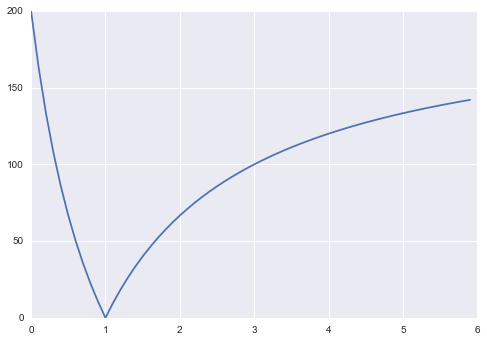

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in all_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    all_df.insert(i, name, infoCol)

all_df.insert(1, 'name', pageInfo[0])
all_df[:3]

,Page,name,project,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


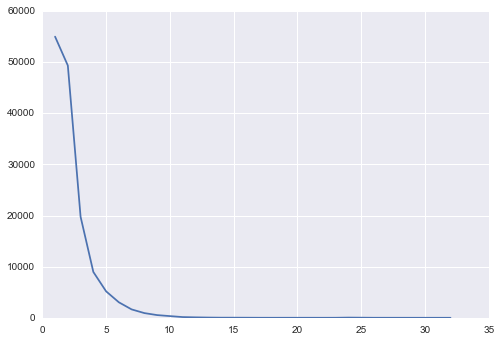

,Page,name,project,access,agent,numWords,2015-07-01,2015-07-02,2015-07-03,2015-07-04,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,18.0,11.0,5.0,13.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,11.0,14.0,15.0,18.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1.0,0.0,1.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [7]:
numWords = []

for name in all_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)
vals, counts = np.unique(numWords, return_counts = True)
plt.plot(vals, counts)
plt.show()
numWords[numWords > 6] = 6

all_df.insert(5, 'numWords', numWords)

all_df[:3]

In [8]:
numNums = []

for name in all_df['name']:
    num = len(re.split(r'\d', name))
    numNums.append(num)
        
numNums = np.array(numNums)
numNums[numNums > 1] = 2
vals, counts = np.unique(numNums, return_counts = True)
print(np.vstack((vals,counts)).T)
print(counts[1:].sum())

all_df.insert(6, 'numNums', numWords)

all_df[:3]

[[     1 130268]
 [     2  14795]]
14795


,Page,name,project,access,agent,numWords,numNums,2015-07-01,2015-07-02,2015-07-03,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,1,1,18.0,11.0,5.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,1,1,11.0,14.0,15.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1,1,1.0,0.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [17]:
futureT = 64

X_all = all_df.drop(['Page', 'name'], axis = 1).values[:, :-futureT]
Y_all = all_df.drop(['Page', 'name'], axis = 1).values[:, -futureT:]

In [18]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 491) 	X_valid.shape =  (32074, 491) 	X_test.shape =  (47871, 491)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [19]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result


def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    means = np.empty((nSamples, 0))
    for i in range(nWindows):
        newCol = X[:, nTimes - 1 - (i+1) * windowSize : nTimes - 1 - i * windowSize].mean(axis = 1, keepdims = True)
        means = np.hstack((means, newCol))
    return means

def all_window_features(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    features = window_means(X, nWindows, windowSize)
    linear = np.empty((nSamples, 0))
    
    # Make linear and quadratic arrays orthogonal to each other.
    const = np.full(windowSize, 1 / np.sqrt(windowSize))
    lin = np.arange(windowSize) - (windowSize - 1) / 2
    
    for i in range(nWindows):
        X_window = X[:, nTimes - 1 - (i + 1)*windowSize : nTimes - 1 - i * windowSize]
        newCol = np.dot(X_window, lin).reshape(-1,1)
        features = np.hstack((features, newCol))
        newCol = np.dot(X_window, lin**2).reshape(-1,1)
        features = np.hstack((features, newCol))
        
    return features

def all_features(X, nWindows, windowSize):
    features = X[:, 0:5]
    window_feat = all_window_features(X[:, 5:], nWindows, windowSize)
    features = np.hstack((features, window_feat))
    return features
    

In [20]:
# Simple tree fit of mean of original data.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape = ', smape(1e-6 + Y_predict, Y_test))

Smape =  110.009820191


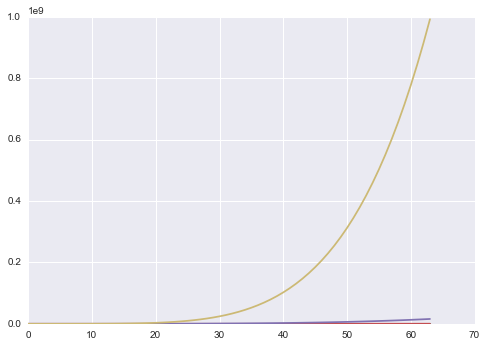

(6, 64)


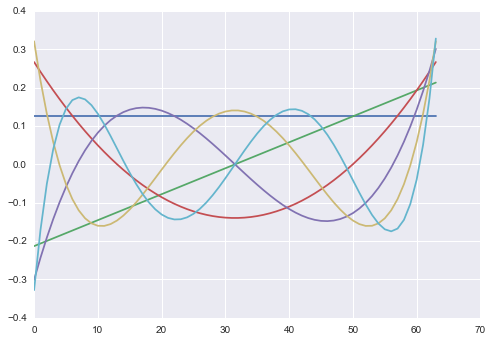

In [22]:
# Let's get an orthonormal basis of polynomials for target values.

nSamples, nYTimes = Y_train.shape
nDegree = 5

polys = np.full((1, nYTimes), 1.0)
for degree in range(1, nDegree + 1, 1):
    newPoly = (np.arange(nYTimes)**degree) . reshape(1,-1)
    polys = np.vstack((polys, newPoly))
    plt.plot(polys[degree,:])
plt.show()

print(polys.shape)
for i in range(nDegree + 1):
    for j in range(i):
        scale = np.dot(polys[i,:], polys[j,:])
        polys[i,:] -= scale * polys[j,:]
    polys[i, :] /= np.linalg.norm(polys[i,:])
    plt.plot(polys[i,:])
plt.show()

In [25]:
Y_train_polys = np.dot(Y_train, polys.T)
print(Y_train_polys.shape)

model.fit(X_train, Y_train_polys)
Y_predict_polys = model.predict(X_valid)
Y_predict = np.dot(Y_predict_polys, polys)
newsmape = smape(Y_predict, Y_valid)
print('smape = ', newsmape)

(65118, 6)
smape =  97.9410598242


In [26]:
model = Pipeline([ ('features', FunctionTransformer(all_features, kw_args = {'nWindows' : 3, 'windowSize' : 41})),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])
Y_train_polys = np.dot(Y_train, polys.T)
model.fit(X_train, Y_train_polys)
Y_predict_polys = model.predict(X_valid)
Y_predict = np.dot(Y_predict_polys, polys)
newsmape = smape(Y_predict, Y_valid)
print('smape = ', newsmape)

smape =  97.9436939435


In [ ]:
model.set_params(tree__max_depth = 70)
Y_train_polys = np.dot(Y_train, polys.T)
print(Y_train_polys.shape)

model.fit(X_train, Y_train_polys)
Y_predict_polys = model.predict(X_valid)
Y_predict = np.dot(Y_predict_polys, polys)
newsmape = smape(1e-6 + Y_predict, Y_valid)
print('smape = ', newsmape)

In [ ]:
# Now, let's try cutting out bad ratio of Y_mean to X_mean.

model.set_params(tree__max_depth = 10)
Y_mean = Y_train.mean(axis = 1)
X_mean = X_train.mean(axis = 1)

cutoff_search = np.arange(1, 10, 0.5)
smapes = []

for cutoff in cutoff_search:
    mask = Y_mean < X_mean * cutoff
    X_train2 = X_train[mask]
    Y_train2 = Y_train[mask]

    Y_train_polys2 = np.dot(Y_train2, polys.T)
    model.fit(X_train2, Y_train_polys2)
    Y_predict_polys = model.predict(X_valid)
    Y_predict = np.dot(Y_predict_polys, polys)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('cutoff = ', cutoff, 'smape = ', newsmape)
    smapes.append(newsmape)
    
plt.plot(cutoff_search, smapes)
plt.show()


In [ ]:
# Let's do a z transform.
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])

# definition of ztransformation.

def ztransform1(Y, param):
    return 1 / (param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ1(Z, param):
    return -param + 1 / Z

epsilon = 1e-6
param_search = np.arange(1, 1000, 100)

smapes = []
for param in param_search:
    Z_train = ztransform1(Y_train, param)
    Z_train_polys = np.dot(Z_train, polys.T)

    model.fit(X_train, Z_train_polys)
    Z_predict_polys = model.predict(X_valid)
    Z_predict = np.dot(Z_predict_polys, polys)
    Y_predict = inverseZ1(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(param_search, smapes)
plt.show()

In [ ]:
# Let's do a z transform.
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])

# definition of ztransformation.

def ztransform2(Y, param):
    return np.log(param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ2(Z, param):
    return -param + np.exp(Z)

epsilon = 1e-6
param_search = np.arange(1, 200, 10)

smapes = []
for param in param_search:
    Z_train = ztransform2(Y_train, param)
    Z_train_polys = np.dot(Z_train, polys.T)

    model.fit(X_train, Z_train_polys)
    Z_predict_polys = model.predict(X_valid)
    Z_predict = np.dot(Z_predict_polys, polys)
    Y_predict = inverseZ2(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(param_search, smapes)
plt.show()

param =  1 smape =  78.03
param =  11 smape =  77.04
param =  21 smape =  76.87
param =  31 smape =  76.87
param =  41 smape =  77.12
param =  51 smape =  77.03
param =  61 smape =  76.96
param =  71 smape =  77.13
param =  81 smape =  77.21
param =  91 smape =  77.30
param =  101 smape =  77.46
param =  111 smape =  77.49
param =  121 smape =  77.44
param =  131 smape =  77.44
param =  141 smape =  77.49
param =  151 smape =  77.54
param =  161 smape =  77.58
param =  171 smape =  77.57
param =  181 smape =  77.70
param =  191 smape =  77.71


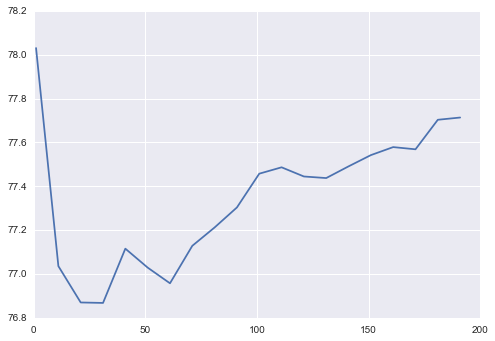

In [24]:
# Let's do a z transform.
model = Pipeline([ ('features', FunctionTransformer(all_features, kw_args = {'nWindows' : 3, 'windowSize' : 41})),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])

# definition of ztransformation.

def ztransform2(Y, param):
    return np.log(param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ2(Z, param):
    return -param + np.exp(Z)

epsilon = 1e-6
param_search = np.arange(1, 200, 10)

smapes = []
for param in param_search:
    Z_train = ztransform2(Y_train, param)
    Z_train_polys = np.dot(Z_train, polys.T)

    model.fit(X_train, Z_train_polys)
    Z_predict_polys = model.predict(X_valid)
    Z_predict = np.dot(Z_predict_polys, polys)
    Y_predict = inverseZ2(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(param_search, smapes)
plt.show()

In [ ]:
# Let's do a z transform.
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])

# definition of ztransformation.

def ztransform3(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)

def inverseZ3(Z, param):
    Z2 = np.minimum(Z, 1 - epsilon)
    Z2 = np.maximum(Z2, -1 + epsilon)
    result = -1 - Z2 * np.sqrt(2 - Z2**2)
    result = result / (Z2**2 - 1)
    result = param * result**2
    return result
epsilon = 1e-6
param_search = np.arange(200, 2600, 200)

smapes = []
for param in param_search:
    Z_train = ztransform3(Y_train, param)
    Z_train_polys = np.dot(Z_train, polys.T)

    model.fit(X_train, Z_train_polys)
    Z_predict_polys = model.predict(X_valid)
    Z_predict = np.dot(Z_predict_polys, polys)
    Y_predict = inverseZ3(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(param_search, smapes)
plt.show()

In [ ]:
# Let's do a z transform.
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', DecisionTreeRegressor(max_depth = 10)) ])

# definition of ztransformation.

def ztransform4(Y, param):
    return np.log(1e-6 + Y) - np.log(param + Y)

# inverse transformation, Y = inverseZ(Z)

def inverseZ4(Z, param):
    return param * np.exp(Z) / (1 - np.exp(Z))

epsilon = 1e-6
param_search = np.arange(1, 600, 50)
cutoff = 7

smapes = []
for param in param_search:
    Z_train = ztransform4(Y_train, param)
    Z_train_polys = np.dot(Z_train, polys.T)

    model.fit(X_train, Z_train_polys)
    Z_predict_polys = model.predict(X_valid)
    Z_predict = np.dot(Z_predict_polys, polys)
    Y_predict = inverseZ4(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param = ', param, 'smape = ', '%.2f' % newsmape)
    smapes.append(newsmape)
    
plt.plot(param_search, smapes)
plt.show()